# Extended range

In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
%matplotlib inline
import sys
from pathlib import Path
sys.path.append(str(Path('..') / 'src'))

import numpy as np
import matplotlib.pyplot as plt

from config import PhysicsConfig, SpikingRadarConfig, ObjectsConfig
from transmitter import SpikingRadarTransmitter
from environment import SpikingRadarChannel_2D
from receiver import SpikingRadarReceiverBinaural
from models.spiking_lif_delay import SpikingLIFDelayEstimator
from output import SpikingRadarResult_2D


In [3]:
# Setup and config

physics_config = PhysicsConfig(wave_type="sound")
model_config = SpikingRadarConfig(
    fs_hz=100_000.0,
    duration_s=0.35,
    spike_prob_per_ms=0.1,
    chirp_duration_s=0.005,
    chirp_bandwidth_hz=5_000.0,
    chirp_start_hz=1_000.0,
    carrier_hz=20_000.0,
    attenuation=0.5,
    noise_std=0.1,
    threshold=0.5,
    lowpass_cutoff_hz=20_000.0,
    receiver_spacing_m=0.2,
)
objects = ObjectsConfig(object_location_2D=(5.0, 2.0))

tau_ms = 5 / model_config.fs_hz

transmitter = SpikingRadarTransmitter(model_config)
environment = SpikingRadarChannel_2D(model_config, physics_config, objects)
receiver = SpikingRadarReceiverBinaural(model_config)
processing_model = SpikingLIFDelayEstimator(
    model_config,
    physics_config,
    max_delay_s=0.35,
    tau_m_s=tau_ms,
    w_tx=1.0,
    w_rx=1.0,
    v_th=1.5,
)


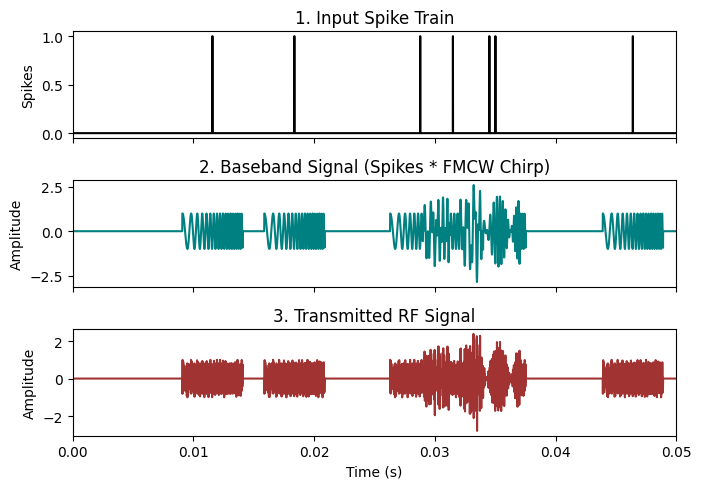

(<Figure size 700x500 with 3 Axes>,
 array([<Axes: title={'center': '1. Input Spike Train'}, ylabel='Spikes'>,
        <Axes: title={'center': '2. Baseband Signal (Spikes * FMCW Chirp)'}, ylabel='Amplitude'>,
        <Axes: title={'center': '3. Transmitted RF Signal'}, xlabel='Time (s)', ylabel='Amplitude'>],
       dtype=object))

In [4]:
# Transmitter

tx = transmitter.build()
transmitter.plot(tx)


In [5]:
# Environment

rx_left, rx_right = environment.propagate(tx.tx_signal)


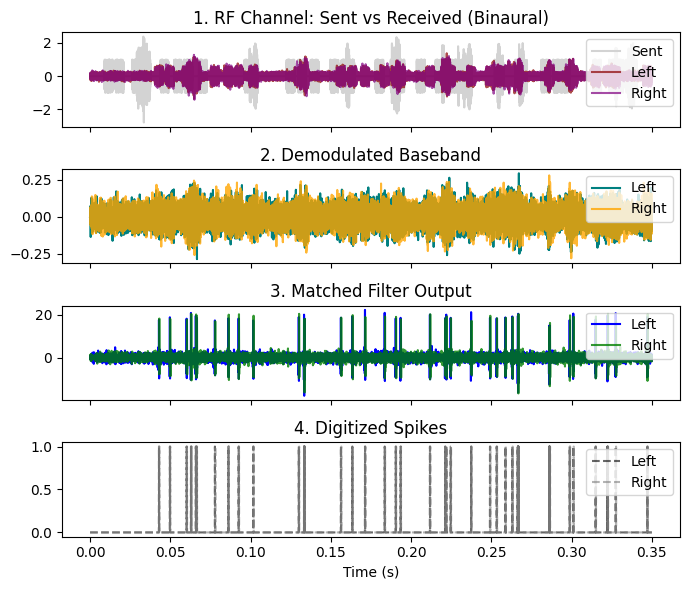

(<Figure size 700x600 with 4 Axes>,
 array([<Axes: title={'center': '1. RF Channel: Sent vs Received (Binaural)'}>,
        <Axes: title={'center': '2. Demodulated Baseband'}>,
        <Axes: title={'center': '3. Matched Filter Output'}>,
        <Axes: title={'center': '4. Digitized Spikes'}, xlabel='Time (s)'>],
       dtype=object))

In [6]:
# Receiver

rx = receiver.process(rx_left, rx_right, tx.time_s, tx.chirp_template)
receiver.plot(tx.time_s, tx.tx_signal, rx)


Text(0.5, 1.0, 'Recovered spikes fed to SNN (Binaural)')

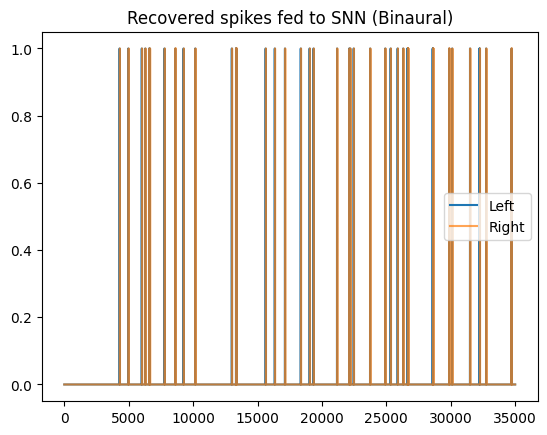

In [7]:
plt.plot(rx.recovered_spikes_left, label="Left")
plt.plot(rx.recovered_spikes_right, label="Right", alpha=0.7)
plt.legend()
plt.title("Recovered spikes fed to SNN (Binaural)")


LIFDelay2DResult(delay_samples_left=3132, delay_samples_right=3154, delay_s_left=0.03132, delay_s_right=0.03154, delay_s=0.03143, distance_m=5.390245, itd_samples=22, itd_s=0.00022, angle_rad=0.38687907883057593, angle_deg=22.166538398901075, spike_counts_left=array([0, 0, 0, ..., 0, 0, 0]), spike_counts_right=array([0, 0, 0, ..., 0, 0, 0]), spike_counts_itd=array([  0,   0,   1,   2,   3,   4,   5,   6,   7,   8,   8,   7,   6,
         5,   4,   3,   2,   1,   0,   0,   0,   1,   2,   3,   4,   5,
         6,   7,   8,   9,   8,   7,   6,   5,   4,   3,   2,   1,   0,
         0,   0,   1,   3,   5,   7,   8,   9,  10,  10,   9,   8,   7,
         8,  11,  14,  17,  19,  20,  21,  19,  17,  15,  13,  17,  24,
        30,  38,  41,  43,  43,  39,  32,  37,  60,  91, 127, 166, 208,
       250, 291, 313, 288, 248, 206, 165, 127,  91,  60,  37,  35,  39,
        43,  43,  41,  37,  31,  25,  18,  16,  19,  21,  23,  23,  20,
        17,  14,  10,   7,   7,   8,  12,  15,  14,  13,  12,  

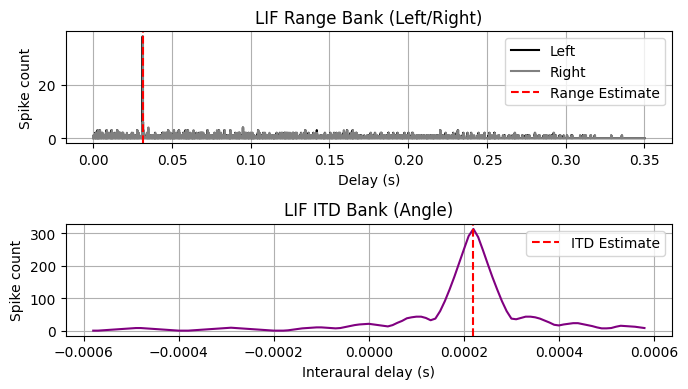

In [8]:
# Processing unit

result = processing_model.estimate_2d(
    tx.spikes,
    rx.recovered_spikes_left,
    rx.recovered_spikes_right,
    receiver_spacing_m=model_config.receiver_spacing_m,
)
print(result)

processing_model.plot_2d(result)

distance_est = result.distance_m
delay_s = result.delay_s
angle_deg = result.angle_deg
itd_s = result.itd_s


In [9]:
# Output

results = SpikingRadarResult_2D(
    distance_m=distance_est,
    delay_s=delay_s,
    angle_deg=angle_deg,
    itd_s=itd_s,
    tx=tx,
    rx=rx,
    objects=objects,
)

results.print_results()

--- RESULTS (2D) ---
Actual Object Location:  (5.00, 2.00) m
Estimated Distance:      5.390 m
Estimated Angle:         22.17 deg
Estimated ITD:           220.0 us


In [ ]:
# Sweep distance at fixed angle, then sweep angle at fixed distance
# 1m 7 to run for (0.0, 50.0, 10)
"""
angle_deg_fixed = 20.0
distances = np.linspace(0.0, 50.0, 10)
distances_measured = []

for d in distances:
    obj_x = d * np.cos(np.deg2rad(angle_deg_fixed))
    obj_y = d * np.sin(np.deg2rad(angle_deg_fixed))
    objects_loop = ObjectsConfig(object_location_2D=(obj_x, obj_y))
    environment = SpikingRadarChannel_2D(model_config, physics_config, objects_loop)

    rx_left, rx_right = environment.propagate(tx.tx_signal)
    rx_loop = receiver.process(rx_left, rx_right, tx.time_s, tx.chirp_template)

    result = processing_model.estimate_2d(
        tx.spikes,
        rx_loop.recovered_spikes_left,
        rx_loop.recovered_spikes_right,
        receiver_spacing_m=model_config.receiver_spacing_m,
    )
    distances_measured.append(result.distance_m)


"""

In [35]:
# Parrallelization of this:

# 1. Define the worker function (your loop body)
# We pass in the variables that change or are needed for calculation
def run_simulation_step(d, angle_fixed, model_conf, phys_conf, tx_obj, rx_processor, model_proc):
    # Calculate coordinates
    obj_x = d * np.cos(np.deg2rad(angle_fixed))
    obj_y = d * np.sin(np.deg2rad(angle_fixed))
    
    # Setup Environment
    objects_loop = ObjectsConfig(object_location_2D=(obj_x, obj_y))
    environment = SpikingRadarChannel_2D(model_conf, phys_conf, objects_loop)

    # Propagate and Process
    rx_left, rx_right = environment.propagate(tx_obj.tx_signal)
    rx_loop = rx_processor.process(rx_left, rx_right, tx_obj.time_s, tx_obj.chirp_template)

    # Estimate
    result = model_proc.estimate_2d(
        tx_obj.spikes,
        rx_loop.recovered_spikes_left,
        rx_loop.recovered_spikes_right,
        receiver_spacing_m=model_conf.receiver_spacing_m,
    )
    return result.distance_m

# 2. Setup your data
angle_deg_fixed = 20.0
distances = np.linspace(0.0, 50.0, 500) # Resolution of 10cm, based on pixel limit of plot


In [ ]:
# Using job lib
# 44s for (0.0, 50.0, 10)
# 25 minutes for (0.0, 50.0, 500)

from joblib import Parallel, delayed

# 3. Run in Parallel
# n_jobs=-1 uses all available CPU cores
distances_measured = Parallel(n_jobs=4)(
    delayed(run_simulation_step)(
        d, 
        angle_deg_fixed, 
        model_config, 
        physics_config, 
        tx, 
        receiver, 
        processing_model
    ) for d in distances
)

In [28]:
# 1m 9s to run for (-90.0, 90.0, 10)
"""
distance_fixed = 5.0
angles_deg = np.linspace(-90.0, 90.0, 10)
angles_measured = []

for a in angles_deg:
    obj_x = distance_fixed * np.cos(np.deg2rad(a))
    obj_y = distance_fixed * np.sin(np.deg2rad(a))
    objects_loop = ObjectsConfig(object_location_2D=(obj_x, obj_y))
    environment = SpikingRadarChannel_2D(model_config, physics_config, objects_loop)

    rx_left, rx_right = environment.propagate(tx.tx_signal)
    rx_loop = receiver.process(rx_left, rx_right, tx.time_s, tx.chirp_template)

    result = processing_model.estimate_2d(
        tx.spikes,
        rx_loop.recovered_spikes_left,
        rx_loop.recovered_spikes_right,
        receiver_spacing_m=model_config.receiver_spacing_m,
    )
    angles_measured.append(result.angle_deg)

"""

'\ndistance_fixed = 5.0\nangles_deg = np.linspace(-90.0, 90.0, 10)\nangles_measured = []\n\nfor a in angles_deg:\n    obj_x = distance_fixed * np.cos(np.deg2rad(a))\n    obj_y = distance_fixed * np.sin(np.deg2rad(a))\n    objects_loop = ObjectsConfig(object_location_2D=(obj_x, obj_y))\n    environment = SpikingRadarChannel_2D(model_config, physics_config, objects_loop)\n\n    rx_left, rx_right = environment.propagate(tx.tx_signal)\n    rx_loop = receiver.process(rx_left, rx_right, tx.time_s, tx.chirp_template)\n\n    result = processing_model.estimate_2d(\n        tx.spikes,\n        rx_loop.recovered_spikes_left,\n        rx_loop.recovered_spikes_right,\n        receiver_spacing_m=model_config.receiver_spacing_m,\n    )\n    angles_measured.append(result.angle_deg)\n\n'

In [37]:
# Parralellization of angles

# 1. Define the worker function for a single angle
def run_angle_step(a, distance_fixed, model_conf, phys_conf, tx_obj, rx_processor, model_proc):
    # Calculate coordinates based on angle 'a'
    obj_x = distance_fixed * np.cos(np.deg2rad(a))
    obj_y = distance_fixed * np.sin(np.deg2rad(a))
    
    # Setup Environment
    objects_loop = ObjectsConfig(object_location_2D=(obj_x, obj_y))
    environment = SpikingRadarChannel_2D(model_conf, phys_conf, objects_loop)

    # Propagate and Process
    rx_left, rx_right = environment.propagate(tx_obj.tx_signal)
    rx_loop = rx_processor.process(rx_left, rx_right, tx_obj.time_s, tx_obj.chirp_template)

    # Estimate
    result = model_proc.estimate_2d(
        tx_obj.spikes,
        rx_loop.recovered_spikes_left,
        rx_loop.recovered_spikes_right,
        receiver_spacing_m=model_conf.receiver_spacing_m,
    )
    return result.angle_deg

# 2. Setup Data
distance_fixed = 5.0
angles_deg = np.linspace(-90.0, 90.0, 361) # 0.5 degree reolution



In [ ]:
# Using joblib
# 25s for (-90.0, 90.0, 10)
# 16 minutes for (-90.0, 90.0, 361)

from joblib import Parallel, delayed

# 3. Run in Parallel
# n_jobs=-1 uses all available CPU cores
angles_measured = Parallel(n_jobs=4)(
    delayed(run_angle_step)(
        a, 
        distance_fixed, 
        model_config, 
        physics_config, 
        tx, 
        receiver, 
        processing_model
    ) for a in angles_deg
)

# Convert to array for easier plotting later if needed
angles_measured = np.array(angles_measured)

Distance RMSE: 0.006 m
Angle RMSE:    1.453 deg


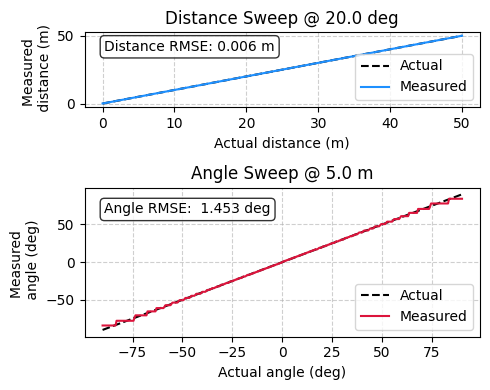

In [ ]:
distances_measured = np.array(distances_measured)
angles_measured = np.array(angles_measured)

dist_rmse = np.sqrt(np.mean((distances_measured - distances) ** 2))
angle_rmse = np.sqrt(np.mean((angles_measured - angles_deg) ** 2))

print(f"Distance RMSE: {dist_rmse:.3f} m")
print(f"Angle RMSE:    {angle_rmse:.3f} deg")

fig, axes = plt.subplots(
    2, 1,
    figsize=(5, 4),
    gridspec_kw={"height_ratios": [1, 2]}
)


axes[0].plot(distances, distances, label="Actual", color="black", linestyle="--")
axes[0].plot(distances, distances_measured, label="Measured", color="dodgerblue")
axes[0].set_title(f"Distance Sweep @ {angle_deg_fixed:.1f} deg")
title_size_0 = axes[0].title.get_size()
axes[0].set_xlabel("Actual distance (m)", fontsize=title_size_0)
axes[0].set_ylabel("Measured \n distance (m)", fontsize=title_size_0)
axes[0].grid(True, linestyle="--", alpha=0.6)
axes[0].legend(loc="lower right")

# Add text box for statistics
stats_text_1 = f'Distance RMSE: {dist_rmse:.3f} m'
axes[0].text(0.05, 0.9, stats_text_1, transform=axes[0].transAxes,
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))


axes[1].plot(angles_deg, angles_deg, label="Actual", color="black", linestyle="--")
axes[1].plot(angles_deg, angles_measured, label="Measured", color="crimson")
axes[1].set_title(f"Angle Sweep @ {distance_fixed:.1f} m")
title_size_1 = axes[1].title.get_size()
axes[1].set_xlabel("Actual angle (deg)", fontsize=title_size_1)
axes[1].set_ylabel("Measured \n angle (deg)", fontsize=title_size_1)
axes[1].grid(True, linestyle="--", alpha=0.6)
axes[1].legend(loc="lower right")


# Add text box for statistics
stats_text_2 = f'Angle RMSE:  {angle_rmse:.3f} deg'
axes[1].text(0.05, 0.9, stats_text_2, transform=axes[1].transAxes,
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))


plt.tight_layout()
plt.show()

/var/folders/9m/5yl447m538l3dw65wfhnx6xh0000gn/T/ipykernel_27207/3002917242.py:2: RuntimeWarning: divide by zero encountered in divide
  dist_err_pct = (distances_measured - distances) * 100.0 / distances
/var/folders/9m/5yl447m538l3dw65wfhnx6xh0000gn/T/ipykernel_27207/3002917242.py:5: RuntimeWarning: invalid value encountered in divide
  (angles_measured - angles_deg) * 100.0 / angles_deg,


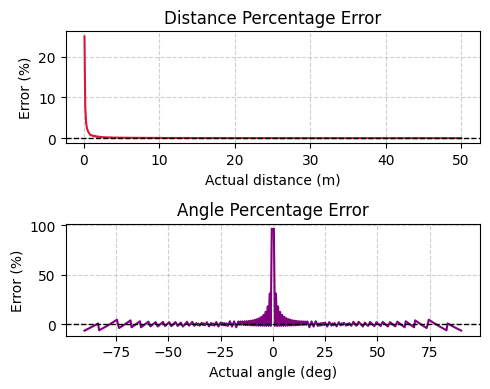

In [43]:
# Percentage error plots for distance and angle sweeps
dist_err_pct = (distances_measured - distances) * 100.0 / distances
angle_err_pct = np.where(
    np.abs(angles_deg) > 1e-9,
    (angles_measured - angles_deg) * 100.0 / angles_deg,
    np.nan,
)
fig, axes = plt.subplots(2, 1, figsize=(5, 4))
axes[0].plot(distances, dist_err_pct, color="crimson")
axes[0].axhline(0, color="black", linestyle="--", linewidth=1)
axes[0].set_title("Distance Percentage Error")
axes[0].set_xlabel("Actual distance (m)")
axes[0].set_ylabel("Error (%)")
axes[0].grid(True, linestyle="--", alpha=0.6)
axes[1].plot(angles_deg, angle_err_pct, color="purple")
axes[1].axhline(0, color="black", linestyle="--", linewidth=1)
axes[1].set_title("Angle Percentage Error")
axes[1].set_xlabel("Actual angle (deg)")
axes[1].set_ylabel("Error (%)")
axes[1].grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()






For your current ITD‑based angle estimate:

ITD bin size (time resolution):
Δt = 1 / fs_hz

Angle from ITD:
θ = asin( (c * ITD) / receiver_spacing_m )

Local angular resolution (small change):
Δθ ≈ (c / (receiver_spacing_m * cos θ)) * Δt (radians)

So at small angles (cos θ ≈ 1):
Δθ ≈ c / (receiver_spacing_m * fs_hz) (radians)
Δθ_deg ≈ (180/π) * c / (receiver_spacing_m * fs_hz) (degrees)

If you also want the range resolution from sampling:
ΔR ≈ c / (2 * fs_hz) (meters)

Using your current values (fs_hz=100_000, receiver_spacing_m=0.2, c=343 m/s):

ITD bin size: Δt = 1/fs = 10 µs
Angle resolution (small angles):
(0.2*100000) = 0.01715 rad ≈ 0.98°
At 40° off‑axis:
 cos(40°) ≈ 1.28°
Range resolution:
(200000) = 0.001715 m ≈ 1.7 mm
If your receiver_spacing_m or fs_hz differs, tell me the values and I’ll recompute.

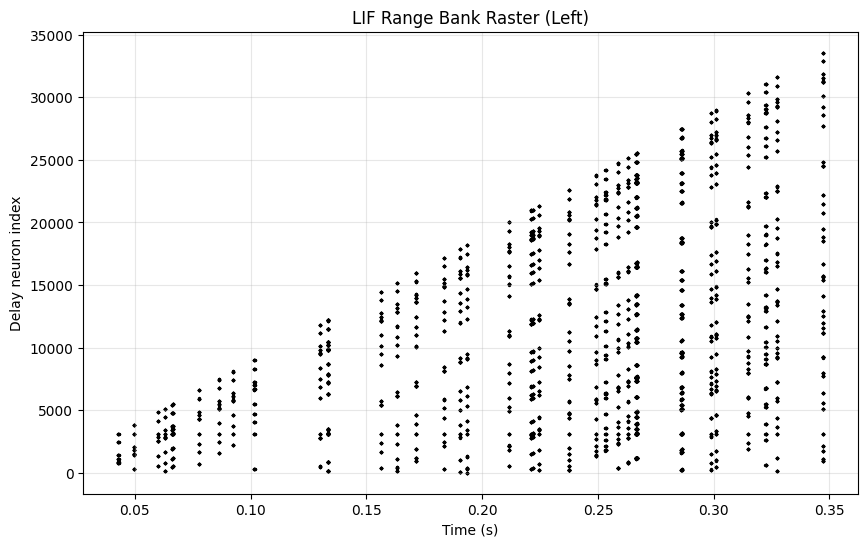

In [14]:
# LIF range bank raster (left channel)
spike_counts_left, spike_times_left = processing_model.run_lif_bank_raster(
    tx.spikes,
    rx.recovered_spikes_left,
)

spike_t = []
spike_i = []
for i, times in enumerate(spike_times_left):
    if times:
        spike_t.extend(np.array(times) / model_config.fs_hz)
        spike_i.extend([i] * len(times))

plt.figure(figsize=(10, 6))
plt.scatter(spike_t, spike_i, s=2, color="black")
plt.xlabel("Time (s)")
plt.ylabel("Delay neuron index")
plt.title("LIF Range Bank Raster (Left)")
plt.grid(True, alpha=0.3)
plt.show()


### Maximum detection distance

The delay bank spans from $ \tau = 0 $ to $ \tau_{\max} $, where

$$
\tau_{\max} = \min(\texttt{max\_delay\_s}, \texttt{duration\_s}).
$$

The maximum detectable range is then given by

$$
R_{\max} = \frac{c \, \tau_{\max}}{2}.
$$

With $ c = 343\,\mathrm{m/s} $ and $ \tau_{\max} = 0.1\,\mathrm{s} $, the maximum range is

$$
R_{\max} \approx 17.15\,\mathrm{m}.
$$


For 50 m (sound), the round‑trip time is:

$ \tau = 2R/c = 2 \cdot 50 / 343 \approx 0.2915 ,\text{s} $
So you need both of these at or above ~0.292 s:

* ``max_delay_s >= 0.292 ``
* `` duration_s >= 0.292 ``

Practical settings:

* ``max_delay_s = 0.30 ``(or 0.35 for margin)
* ``duration_s = 0.30 ``(or 0.35)

Everything else can stay the same. With ``fs_hz=100_000``, this means ~29,150 samples of delay capacity.


### Resolution equations

Distance (range) resolution from sampling:
$$\Delta R \approx \frac{c}{2 f_s}$$

Angle resolution (small-angle approximation):
$$\Delta \theta \approx \frac{c}{d \, f_s}$$

Angle resolution at a general angle $\theta$ (far-field):
$$\Delta \theta(\theta) \approx \frac{c}{d \, f_s \cos\theta}$$

With $c=343\,\mathrm{m/s}$, $f_s=100000\,\mathrm{Hz}$, and $d=0.2\,\mathrm{m}$:
- $\Delta R \approx 0.001715\,\mathrm{m}$ (about 1.71 mm)
- $\Delta \theta \approx 0.01715\,\mathrm{rad}$ (about 0.98 deg) at small angles
